# Step #1 Load the Data

In [2]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # For analysing and manipulating data
from datetime import date, timedelta # Date Functions
from pandas.plotting import register_matplotlib_converters # Adds plotting functions for calender dates
import matplotlib.pyplot as plt # For visualization
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # For measuring model performance / errors
from sklearn.preprocessing import MinMaxScaler #to normalize the price data 
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense # Deep learning classes for recurrent and regular densely-connected layers

# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'

# Remote data access
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=date_start, end=date_today, data_source="yahoo")
import yfinance as yf # Used if webreader does not work: pip install yfinance
df = yf.download(symbol, start=date_start, end=date_today)

# Taking a look at the shape of the dataset
print(df.shape)
df.head(5)

[*********************100%***********************]  1 of 1 completed
(2897, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,1126.599976,1127.640015,1114.810059,1115.099976,1115.099976,2076990000
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000


# Step #2 Explore the Data

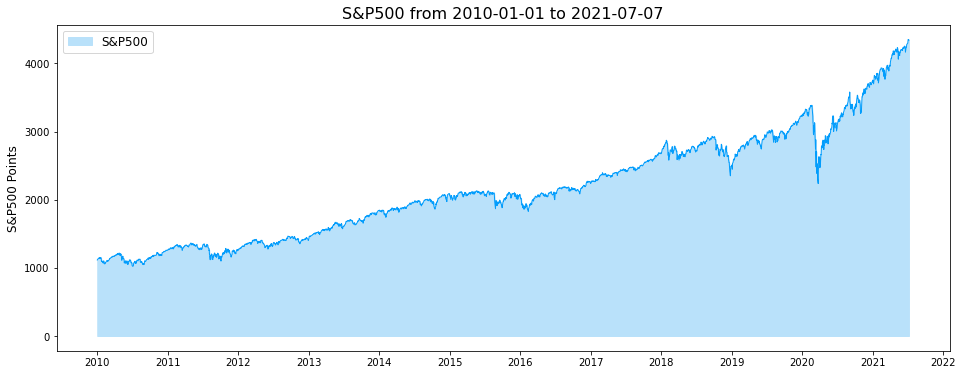

In [3]:
# Plotting the data
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df.index
y = df['Close']
ax1.fill_between(x, 0, y, color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ date_start + ' to ' + date_today, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('S&P500 Points', fontsize=12)
plt.show()

# Step #3 Preprocess the Data

In [4]:
# Feature Selection - Only Close Data
data = df.filter(['Close'])
data_unscaled = data.values

# Get the number of rows to train the model on 80% of the data 
training_data_length = math.ceil(len(data_unscaled) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
np_data = mmscaler.fit_transform(data_unscaled)

In [5]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")
print(index_Close)
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.8)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_test[1][sequence_length-1][index_Close])
print(y_test[0])

0
(2268, 50, 1) (2268,)
(579, 50, 1) (579,)
0.5410750496038066
0.5410750496038066


# Step #4 Design the Model Architecture

In [6]:
# Configure the neural network model
model = Sequential()

neurons = sequence_length

# Model with sequence_length Neurons 
# inputshape = sequence_length Timestamps
model.add(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(neurons, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step #5 Train the Model

In [7]:
# Training the model
model.fit(x_train, y_train, batch_size=16, epochs=25)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/25
142/142 [==============================] - 18s 16ms/step - loss: 0.0029
Epoch 2/25
142/142 [==============================] - 2s 17ms/step - loss: 1.3969e-04
Epoch 3/25
142/142 [==============================] - 2s 16ms/step - loss: 1.4059e-04
Epoch 4/25
142/142 [==============================] - 2s 16ms/step - loss: 1.4376e-04
Epoch 5/25
142/142 [==============================] - 2s 15ms/step - loss: 1.3792e-04
Epoch 6/25
142/142 [==============================] - 2s 15ms/step - loss: 1.3706e-04
Epoch 7/25
142/142 [==============================] - 2s 15ms/step - loss: 1.2659e-04
Epoch 8/25
142/142 [==============================] - 2s 15ms/step - loss: 1.3741e-04
Epoch 9/25
142/142 [==============================] - 2s 15ms/step - loss: 1.2036e-04
Epoch 10/25
142/142 [==============================] - 2s 16ms/step - loss: 1.3251e-04
Epoc

# Step #6 Make Predictions

In [8]:
# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

# Step #7 Evaluate Model Performance

In [9]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('MAE: ' + str(round(mae, 1)))

# Calculate the root mean squarred error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE: ' + str(round(rmse, 1)))

MAE: 3271.7
RMSE: 3271.7


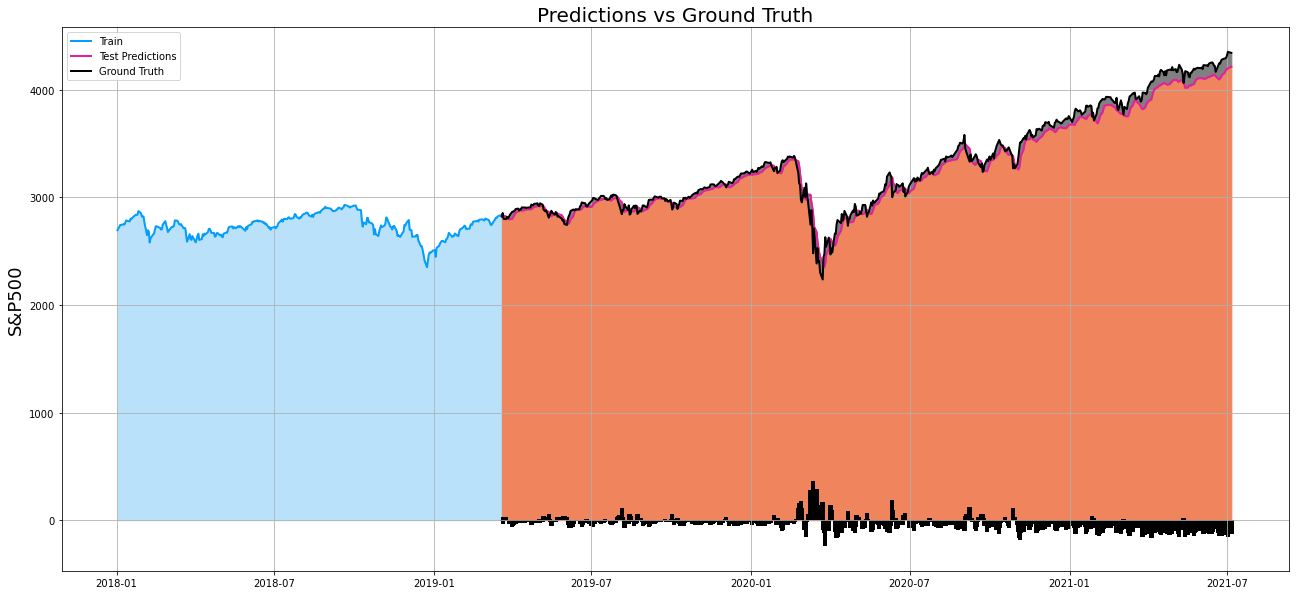

In [10]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = data[:training_data_length + 1]
valid = data[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=2.0)
plt.plot(yv["Predictions"], color="#E91D9E", linewidth=2.0)
plt.plot(yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="grey") 

# Create the bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

In [11]:
# Show the valid and predicted prices
dif = valid['Close'] - valid['Predictions']
valid.insert(2, 'Difference', dif, True)
valid.tail(5)

,Close,Difference,Difference,Predictions
Date,,,,
2021-06-29,4291.799805,-118.394531,118.394531,4173.405273
2021-06-30,4297.500000,-112.508789,112.508789,4184.991211
2021-07-01,4319.939941,-128.393066,128.393066,4191.546875
2021-07-02,4352.339844,-152.113281,152.113281,4200.226562
2021-07-06,4343.540039,-128.366699,128.366699,4215.173340


# Step #8 Predict Next Day's Price

In [12]:
# Get fresh data until today
df_new = df.filter(['Close'])

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_days_scaled = mmscaler.transform(df_new[-sequence_length:].values)

# Create an empty list and Append past n days
X_test = []
X_test.append(last_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price_unscaled = mmscaler.inverse_transform(pred_price)

# Print last price and predicted price for the next day
price_today = round(df_new['Close'][-1], 2)
predicted_price = round(pred_price_unscaled.ravel()[0], 2)
percent = round(100 - (predicted_price * 100)/price_today, 2)

plus = '+'; minus = '-'
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if percent > 0 else minus}{percent}%)')

The close price for S&P500 at 2021-07-07 was 4343.54
The predicted close price is 4225.919921875 (+2.71%)
